In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preliminaries

In [ ]:
%%bash
pip install keras==2.3.1
pip install tensorflow==2.2.0
pip install keras_applications==1.0.8
pip install image-classifiers==1.0.0
pip install efficientnet==1.0.0
pip install keras-unet
pip install tf-semantic-segmentation
pip install segmentation-models

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
#function ClickConnect(){ console.log("Working2"); document.querySelector("colab-toolbar-button#connect").click() }setInterval(ClickConnect,10000)

In [ ]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import scipy.io as sio
import pandas as pd
import time

Using TensorFlow backend.


### Functions

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
def tversky(y_true, y_pred,  smooth=1.):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

In [ ]:
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [ ]:
#Versión de tensor
'''def dice_coef(y_true, y_pred, smooth=1.):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    denom=K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1)
    return (2. * intersection + smooth) / (denom + smooth)'''

'def dice_coef(y_true, y_pred, smooth=1.):\n    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)\n    denom=K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1)\n    return (2. * intersection + smooth) / (denom + smooth)'

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

In [ ]:
def weighted_cross_entropyloss(y_true, y_pred, beta = 0.25):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)
    return tf.reduce_mean(loss)

In [ ]:
def log_cosh_dice_loss(y_true, y_pred):
    x = dice_coef_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def false_positive_rate(y_true, y_pred):
    return 1-specificity(y_true, y_pred)

In [ ]:
losses={'binary_crossentropy': 'binary_crossentropy', 'dice_coef_loss': dice_coef_loss, 'weighted_cross_entropyloss': weighted_cross_entropyloss, 'tversky_loss': tversky_loss, 'log_cosh_dice_loss': log_cosh_dice_loss}
n_losses=['binary_crossentropy', 'dice_coef_loss', 'weighted_cross_entropyloss', 'tversky_loss', 'log_cosh_dice_loss']

In [ ]:
def plot_t(his_m, mtc='acc', name='none'):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(his_m.history[mtc])
  plt.plot(his_m.history['val_'+mtc])
  plt.title(mtc)
  plt.ylabel(mtc)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(his_m.history['loss'])
  plt.plot(his_m.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('value')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  if not name=='none':
    plt.savefig(name)

In [ ]:
def plot_image_mask(ima, mas,  name='none'):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(ima, cmap='inferno')
  plt.title('Image')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(mas, cmap='gray')
  plt.title('Mask')
  plt.axis('off')

  if not name=='none':
    plt.savefig(name)

In [ ]:
def three_plot(ori, s_predi, s_real, name='none'):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.imshow(ori, cmap='inferno')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(s_predi, cmap='hot')
  plt.title('predicted segmentation')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(s_real, cmap='gray')
  plt.title('real segmentation')
  plt.axis('off')

  if not name=='none':
    plt.savefig(name)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [ ]:
from keras_unet.models import custom_unet
from segmentation_models import Unet, Linknet, FPN, PSPNet

def read_model(net, inputshape=(256,256,3)):
  not_p=True
  if net=='unet_cus':
    model = custom_unet((256,256,3), use_batch_norm=True)
    not_p=False
  
  if net=='multiresunet':
    model=MultiResUnet(256,256,3)
    not_p=False

  if net=='mobileNet':
    model=Unet('mobilenet', inputshape, 1)
    not_p=False

  if net=='unetVgg16':
    model=Unet('vgg16', inputshape, 1)
    not_p=False
  
  if net=='linknet':
    model=Linknet('efficientnetb5', inputshape)
    not_p=False

  if net=='densenet201':
    model=Unet('densenet201',inputshape,1)
    not_p=False

  if net=='inceptionresnetv2':
    model=Unet('inceptionresnetv2',inputshape,1)
    not_p=False 

  if not_p:
    print('Network name does not exist')

  return model

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `tf.keras` framework.


### Data and Folders

In [ ]:
path="/content/drive/MyDrive/INDIGO_MLR/TumoresCerebrales/"
pathW=path+'Weights/'
figures=path+'Figures/'

In [ ]:
mats=glob.glob(path+'*.mat')
print(np.shape(mats))

(7,)


In [ ]:
images=[]
masks=[]
labels=[]

for n, i in enumerate(mats):
  data=sio.loadmat(i)
  n_sub,rows,cols=np.shape(data['images'])
  labels=np.append(labels,data['labels'][0])
  ima=np.array(data['images'], np.dtype('float32')).reshape((n_sub,rows,cols,1))
  mks=np.array(data['masks'], np.dtype('float32')).reshape((n_sub,rows,cols,1))
  if n==0:   
    images=ima
    masks=mks
  else:
    images=np.concatenate((images,ima))
    masks=np.concatenate((masks,mks))

### Select tumor cancer type (and randomize)

In [ ]:
tumor_t=1

if tumor_t==0:
  imagest=images
  maskst=masks
else:
  tumor=np.where(labels==tumor_t)[0]
  imagest=images[tumor]
  maskst=masks[tumor]

In [ ]:
#imagest=tf.image.resize(imagest, [480,480], method='nearest')
#maskst=tf.image.resize(masks, [480,480], method='nearest')

In [ ]:
d_size=np.shape(imagest)[0]
indx=np.random.choice(d_size, d_size, replace=False)

imagest=np.array(imagest)[indx]
maskst=np.array(maskst)[indx]

(708, 512, 512, 1) (708, 512, 512, 1)


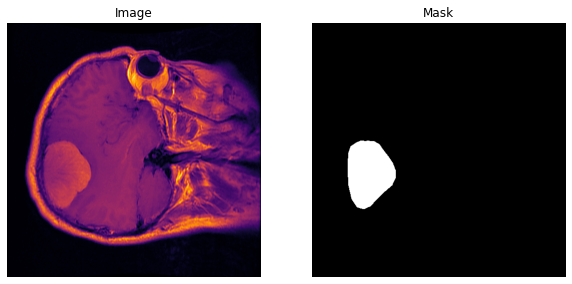

In [ ]:
print(np.shape(imagest), np.shape(maskst))
n_sub=np.shape(imagest)[0]
ind=np.random.choice(n_sub)
plot_image_mask(imagest[ind,:,:,0], maskst[ind,:,:,0])

### Split data

### Gray to RGB

In [ ]:
shap=np.shape(imagest)
imagesRGB=np.zeros((shap[0], shap[1], shap[2], 3))
imagesRGB[...,0]=imagesRGB[...,1]=imagesRGB[...,2]=imagest[...,0]
imagest=imagesRGB

In [ ]:
sp=int(n_sub*0.8)
sp2=int(sp*0.8)

x_test=imagest[sp:]; x_train=imagest[:sp2]; x_val=imagest[sp2:sp]
y_test=maskst[sp:]; y_train=maskst[:sp2]; y_val=maskst[sp2:sp]

In [ ]:
print(np.shape(x_test), np.shape(x_train), np.shape(x_val))

(142, 512, 512, 3) (452, 512, 512, 3) (114, 512, 512, 3)


### Data frame

In [ ]:
df = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))
df.head()

,tumor_type,run_n,network,optimizer,loss,epochs,total_parameters,time,augm,jaccard_distances,acc,sensitivity,specificity,FPR,dice_coef,result_mat


In [ ]:
del mats, images, imagest, masks, maskst, n, i, rows, cols, ima, mks, n_sub, data, tumor, d_size, ind, indx

### Training Model and save data

In [ ]:
from IPython.display import clear_output

epochs=100
optimizer='Adam'
augmentation='none'

network='linknet'

name_0='_'.join(['f_cancer_'+str(tumor_t),network,optimizer])

if not os.path.exists(path+name_0+'.csv'):
  df.to_csv(path+name_0+'.csv')

for i in range(2,5):
  for j in n_losses:
    cntn=True
    tic = time.time()
    name_m='_'.join([name_0,j,'run',str(i)])  
    print(name_m)

    try:
      del model
    except:
      print('done')

    model=read_model(network)
    model.compile(optimizer=optimizer, loss=losses[j], metrics=['acc', jaccard_distance, dice_coef])

    ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
    MCP = ModelCheckpoint(filepath=pathW+name_m+'_w.hdf5', save_best_only=True, save_weights_only=True)
    
    try:
      results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=4, epochs=epochs)
      model.save_weights(pathW+name_m+"w.h5")
    except:
      print('Training error')
      cntn=False

    if cntn:
      sio.savemat(pathW+name_m+'_r.mat', results.history)

      #Validation
      
      y_hat=model.predict(x_test)

      acc=np.mean((y_test>0.5)==(y_hat>0.5))
      jxd=np.mean(jaccard_distance(y_test, y_hat))
      dic=np.mean(dice_coef(y_test, y_hat))
      sensi=float(sensitivity(y_test, y_hat))
      speci=float(specificity(y_test, y_hat))
      total_p=model.count_params()
      toc=time.time()-tic

      #data frame
      df2=pd.read_csv(path+name_0+'.csv')
      df2=df2.append({'tumor_type': tumor_t,
                    'run_n': i,
                    'network': network,
                    'optimizer': optimizer,
                    'loss': j,
                    'epochs': epochs,
                    'total_parameters': total_p,
                    'time': toc,'augm': augmentation,
                    'jaccard_distances': jxd,
                    'acc': acc,
                    'sensitivity': sensi,
                    'specificity': speci,
                    'FPR': 1-speci,
                    'dice_coef': dic,
                    'result_mat': name_m+'_r.mat'} , ignore_index=True)
      
      df2.to_csv(path+name_0+'.csv')
      clear_output(wait=True)

f_cancer_1_linknet_Adam_log_cosh_dice_loss_run_2
Epoch 1/100
113/113 [==============================] - 49s 429ms/step - loss: 0.1056 - acc: 0.9769 - jaccard_distance: 0.0500 - dice_coef: 0.6080 - val_loss: 0.2399 - val_acc: 0.9685 - val_jaccard_distance: 0.0754 - val_dice_coef: 0.2818
Epoch 2/100
113/113 [==============================] - 46s 403ms/step - loss: 0.0077 - acc: 0.9969 - jaccard_distance: 0.0038 - dice_coef: 0.8881 - val_loss: 0.0130 - val_acc: 0.9960 - val_jaccard_distance: 0.0052 - val_dice_coef: 0.8487
Epoch 3/100
113/113 [==============================] - 46s 405ms/step - loss: 0.0041 - acc: 0.9976 - jaccard_distance: 0.0028 - dice_coef: 0.9176 - val_loss: 0.0087 - val_acc: 0.9960 - val_jaccard_distance: 0.0044 - val_dice_coef: 0.8872
Epoch 4/100
113/113 [==============================] - 44s 394ms/step - loss: 0.0044 - acc: 0.9975 - jaccard_distance: 0.0028 - dice_coef: 0.9168 - val_loss: 0.0067 - val_acc: 0.9964 - val_jaccard_distance: 0.0041 - val_dice_coef: 0.8887

### Graphics

In [ ]:
plot_t(results, 'acc', figures+name_0+'_accuracy.svg')

In [ ]:
plot_t(results, 'jaccard_distance', figures+name_0+'_jaccard_distance.svg')

In [ ]:
plot_t(results, 'dice_coef', figures+name_0+'_results.svg')

In [ ]:
y_hat=model.predict(x_test)
np.shape(y_hat)

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+name_0+'_results.svg')